In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
# Load your dataset
df = pd.read_csv("/kaggle/input/mail-dataset/mail_data.csv")
df



,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
# Preprocess the data
df['Category'] = df['Category'].map({'spam': 1, 'ham': 0})

In [10]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
train_encodings = tokenizer(list(train_data['Message']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_data['Message']), truncation=True, padding=True)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_data['Category']
)).shuffle(100).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_data['Category']
)).batch(32)


In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

In [15]:
model.compile(optimizer='adam', loss=loss_fn, metrics=metrics)
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
140/140 [==============================] - 268s 2s/step - loss: 0.4562 - accuracy: 0.8510 - val_loss: 0.3949 - val_accuracy: 0.8664
Epoch 2/5
140/140 [==============================] - 219s 2s/step - loss: 0.4143 - accuracy: 0.8658 - val_loss: 0.4290 - val_accuracy: 0.8664
Epoch 3/5
140/140 [==============================] - 219s 2s/step - loss: 0.4187 - accuracy: 0.8654 - val_loss: 0.3950 - val_accuracy: 0.8664
Epoch 4/5
140/140 [==============================] - 219s 2s/step - loss: 0.4159 - accuracy: 0.8658 - val_loss: 0.4213 - val_accuracy: 0.8664
Epoch 5/5
140/140 [==============================] - 219s 2s/step - loss: 0.4170 - accuracy: 0.8658 - val_loss: 0.4119 - val_accuracy: 0.8664


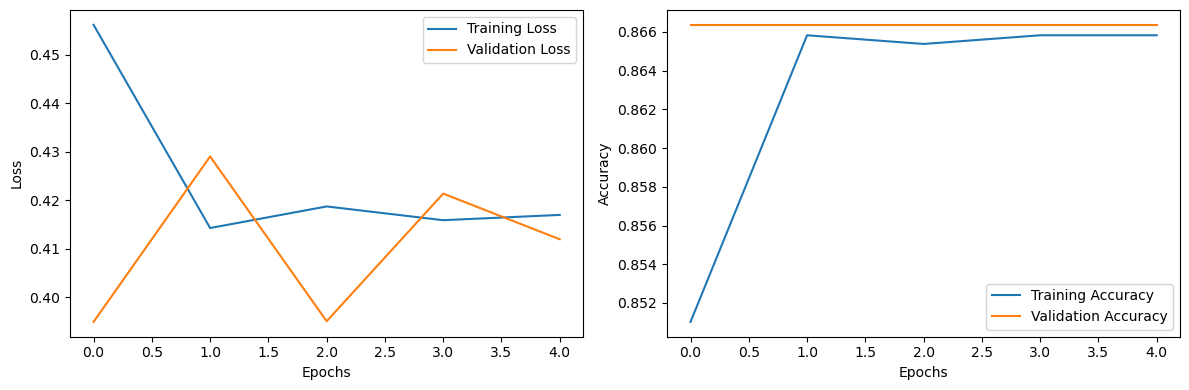

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


35/35 [==============================] - 11s 307ms/step


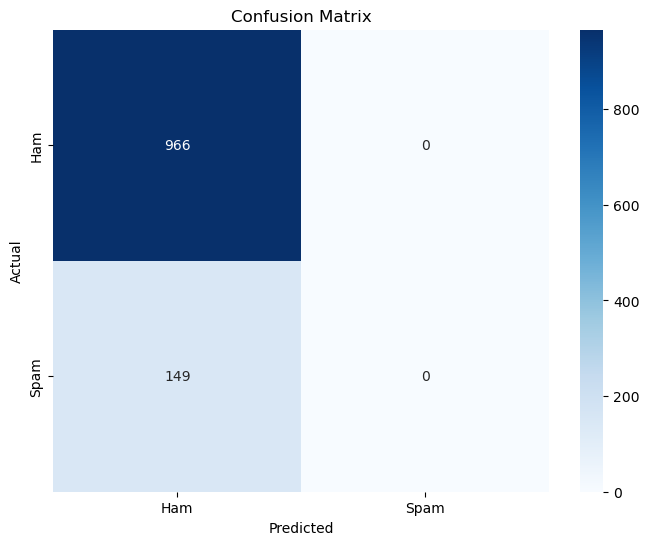

In [18]:
test_predictions = model.predict(test_dataset)
test_predictions = np.argmax(test_predictions.logits, axis=-1)
test_labels = test_data['Category'].values

cm = confusion_matrix(test_labels, test_predictions)

class_labels = ['Ham', 'Spam']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
